In [3]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import rtree
import pickle

from sklearn.model_selection import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
from sklearn.metrics import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from run_model import *
import gmaps
gmaps.configure(api_key=secret_key.google_api_key)

In [30]:
def clean_mta(df, mta_loc):
    df['DATE'] = pd.to_datetime(df.DATE)
    df['month'] = df.DATE.dt.month
    df['year'] = df.DATE.dt.year
    df['day_of_week'] = df.DATE.dt.weekday_name
    df['TIME'] = pd.to_datetime(df['TIME'], format='%H:%M:%S')
    df['time_of_day'] = df.TIME.dt.hour
    df['DATE'] = pd.to_datetime(df.DATE).dt.date

    df = df.rename(index=str, columns={'EXITS                                                               ': "exits"})
    df['exits_d'] = df['exits'].diff().abs()
    df['entry_d'] = df['ENTRIES'].diff().abs()
    
    df = df[df.time_of_day != 3]
    
#     df = df[df.exits_d < 8600]

    df['day_of_the_month'] = pd.to_datetime(df.DATE).dt.day
    df['zone'] = df['STATION'] + " " + df['LINENAME'] + " " + df['DIVISION']

    df = df.groupby(['zone', 'DATE', 'time_of_day'])[['exits_d','entry_d']].sum().reset_index()

    return df

In [31]:
mta_df = pd.read_csv("data/mta_turnstile/turnstile_170107.txt")
mta_df = mta_df.append(pd.read_csv("data/mta_turnstile/turnstile_170114.txt"))
mta_df = mta_df.append(pd.read_csv("data/mta_turnstile/turnstile_170121.txt"))
mta_df = mta_df.append(pd.read_csv("data/mta_turnstile/turnstile_170128.txt"))
mta_loc = load_pickle('storage/mta_loc.pckl')
# mta_df.head()
mta_df = clean_mta(mta_df, mta_loc)

In [ ]:
mta_df.head()

In [32]:
bike_df = load_pickle('storage/test_bike.pckl')
# mta_df = load_pickle('storage/test_mta.pckl')
bike_df = bike_df[bike_df.zone != 'B\'WAY-LAFAYETTE BDFQ6 IND']
agg_mta = mta_df.groupby(['zone', 'DATE', 'time_of_day'])[['exits_d', 'entry_d']].sum().reset_index()

data = pd.merge(bike_df, mta_df, on=['zone', 'DATE', 'time_of_day'])

df = data.sort_values('DATE')

rows = df.shape[0]



In [33]:
df['Bike ID'].describe()

count    174467.000000
mean      21723.249497
std        4191.016960
min       14529.000000
25%       17894.000000
50%       21310.000000
75%       25799.000000
max       27325.000000
Name: Bike ID, dtype: float64

In [36]:
df.head()

Trip Duration          Start Time           Stop Time  Start Station ID  \
0              1436 2017-01-01 04:00:22 2017-01-01 04:24:19               146   
2797           1226 2017-01-01 15:49:21 2017-01-01 16:09:47              3349   
2798           1537 2017-01-01 15:50:22 2017-01-01 16:15:59              3349   
2799           1529 2017-01-01 15:50:26 2017-01-01 16:15:55              3349   
2800           1528 2017-01-01 15:50:32 2017-01-01 16:16:00              3349   

                    Start Station Name  Start Station Latitude  \
0                 Hudson St & Reade St               40.716250   
2797  Grand Army Plaza & Plaza St West               40.672968   
2798  Grand Army Plaza & Plaza St West               40.672968   
2799  Grand Army Plaza & Plaza St West               40.672968   
2800  Grand Army Plaza & Plaza St West               40.672968   

      Start Station Longitude  End Station ID             End Station Name  \
0                  -74.009106             276      Duane St & Greenwich St   
2797               -73.970880             241  DeKalb Ave & S Portland Ave   
2798               -73.970880             282           Kent Ave & S 11 St   
2799               -73.970880             282           Kent Ave & S 11 St   
2800               -73.970880             282           Kent Ave & S 11 St   

      End Station Latitude  End Station Longitude  Bike ID   User Type  \
0                40.717488             -74.010455    17121  Subscriber   
2797             40.689810             -73.974931    26107  Subscriber   
2798             40.707645             -73.968415    26380    Customer   
2799             40.707645             -73.968415    21310    Customer   
2800             40.707645             -73.968415    16737    Customer   

      Birth Year  Gender  month  year day_of_week  time_of_day  \
0         1980.0       1      1  2017      Sunday            7   
2797      1982.0       1      1  2017      Sunday           19   
2798         NaN       0      1  2017      Sunday           19   
2799         NaN       0      1  2017      Sunday           19   
2800         NaN       0      1  2017      Sunday           19   

                     zone        DATE  exits_d  entry_d  
0     CHAMBERS ST 123 IRT  2017-01-01    218.0    122.0  
2797  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0  
2798  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0  
2799  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0  
2800  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0

In [281]:
ini = bike_df.groupby('Start Station ID').count().reset_index()

In [282]:
ini.shape

(238, 21)

In [37]:
train = df.head(int(rows*0.8))
test = df.tail(int(rows*0.2))

In [287]:
df.groupby('Start Station ID').count().reset_index().shape

(186, 23)

In [6]:
bike_df['weight'] = 1
bike_df.head()

Trip Duration          Start Time           Stop Time  Start Station ID  \
0            680 2017-01-01 00:00:21 2017-01-01 00:11:41              3226   
1           1282 2017-01-01 00:00:45 2017-01-01 00:22:08              3263   
6            559 2017-01-01 00:05:00 2017-01-01 00:14:20               499   
7            826 2017-01-01 00:05:37 2017-01-01 00:19:24               362   
8            255 2017-01-01 00:05:47 2017-01-01 00:10:02               430   

            Start Station Name  Start Station Latitude  \
0  W 82 St & Central Park West               40.782750   
1       Cooper Square & E 7 St               40.729236   
6           Broadway & W 60 St               40.769155   
7           Broadway & W 37 St               40.751726   
8             York St & Jay St               40.701485   

   Start Station Longitude  End Station ID             End Station Name  \
0               -73.971370            3165  Central Park West & W 72 St   
1               -73.990868             498           Broadway & W 32 St   
6               -73.981918             479              9 Ave & W 45 St   
7               -73.987535             445           E 10 St & Avenue A   
8               -73.986569             242   Carlton Ave & Flushing Ave   

   End Station Latitude  End Station Longitude  Bike ID   User Type  \
0             40.775794             -73.976206    25542  Subscriber   
1             40.748549             -73.988084    21136  Subscriber   
6             40.760193             -73.991255    27294  Subscriber   
7             40.727408             -73.981420    23288  Subscriber   
8             40.697787             -73.973736    25041  Subscriber   

   Birth Year  Gender  month  year day_of_week  time_of_day  \
0      1965.0       2      1  2017      Sunday            3   
1      1987.0       2      1  2017      Sunday            3   
6      1973.0       1      1  2017      Sunday            3   
7      1977.0       2      1  2017      Sunday            3   
8      1989.0       1      1  2017      Sunday            3   

                       zone        DATE  weight  
0       81 ST-MUSEUM BC IND  2017-01-01       1  
1          8 ST-NYU NRW BMT  2017-01-01       1  
6  59 ST COLUMBUS 1ABCD IRT  2017-01-01       1  
7    34 ST-PENN STA 123 IRT  2017-01-01       1  
8             YORK ST F IND  2017-01-01       1

In [8]:
df['weight'] = 5
ini = pd.merge(df, bike_df, on='Bike ID')

MemoryError: 

In [1]:
locations = ini[['Station_Latitude', 'Station_Longitude']]
#Get the magnitude from the data
weights = ini['weight']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

NameError: name 'ini' is not defined

In [208]:
bike_df.head()

Trip Duration          Start Time           Stop Time  Start Station ID  \
0            680 2017-01-01 00:00:21 2017-01-01 00:11:41              3226   
1           1282 2017-01-01 00:00:45 2017-01-01 00:22:08              3263   
6            559 2017-01-01 00:05:00 2017-01-01 00:14:20               499   
7            826 2017-01-01 00:05:37 2017-01-01 00:19:24               362   
8            255 2017-01-01 00:05:47 2017-01-01 00:10:02               430   

            Start Station Name  Start Station Latitude  \
0  W 82 St & Central Park West               40.782750   
1       Cooper Square & E 7 St               40.729236   
6           Broadway & W 60 St               40.769155   
7           Broadway & W 37 St               40.751726   
8             York St & Jay St               40.701485   

   Start Station Longitude  End Station ID             End Station Name  \
0               -73.971370            3165  Central Park West & W 72 St   
1               -73.990868             498           Broadway & W 32 St   
6               -73.981918             479              9 Ave & W 45 St   
7               -73.987535             445           E 10 St & Avenue A   
8               -73.986569             242   Carlton Ave & Flushing Ave   

   End Station Latitude  End Station Longitude  Bike ID   User Type  \
0             40.775794             -73.976206    25542  Subscriber   
1             40.748549             -73.988084    21136  Subscriber   
6             40.760193             -73.991255    27294  Subscriber   
7             40.727408             -73.981420    23288  Subscriber   
8             40.697787             -73.973736    25041  Subscriber   

   Birth Year  Gender  month  year day_of_week  time_of_day  \
0      1965.0       2      1  2017      Sunday            3   
1      1987.0       2      1  2017      Sunday            3   
6      1973.0       1      1  2017      Sunday            3   
7      1977.0       2      1  2017      Sunday            3   
8      1989.0       1      1  2017      Sunday            3   

                       zone        DATE  
0       81 ST-MUSEUM BC IND  2017-01-01  
1          8 ST-NYU NRW BMT  2017-01-01  
6  59 ST COLUMBUS 1ABCD IRT  2017-01-01  
7    34 ST-PENN STA 123 IRT  2017-01-01  
8             YORK ST F IND  2017-01-01

In [116]:
bike_df.groupby(['Start Station Name', ])['Start Station ID'].count()

Start Station Name
1 Ave & E 16 St                      3370
1 Ave & E 68 St                      3508
10 St & 5 Ave                         204
10 St & 7 Ave                         391
12 St & 4 Ave                         151
21 St & 41 Ave                        137
3 Ave & E 62 St                      1090
3 Ave & E 71 St                       628
3 Ave & E 72 St                       558
3 St & Hoyt St                        254
4 Ave & 9 St                          382
44 Dr & Jackson Ave                   393
48 Ave & 5 St                         193
5 Ave & E 63 St                       474
6 Ave & 9 St                          458
6 Ave & Broome St                    1402
6 Ave & W 33 St                      3134
8 Ave & W 16 St                      2536
8 Ave & W 52 St                      2005
Albany Ave & Fulton St                 91
Allen St & Hester St                 1792
Allen St & Rivington St              2210
Allen St & Stanton St                2524
Amsterdam Ave &

In [38]:
def split_for_model(data):
    grp = data.groupby(['zone', 'DATE', 'time_of_day'])

    df = grp['Bike ID'].count().reset_index()
    df = pd.merge(df, agg_mta, on=['zone', 'DATE', 'time_of_day'])
    df = dummify(df)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['day_of_week'] = df['DATE'].dt.weekday
    df['day_of_month'] = df['DATE'].dt.day
    df['log_bike_id'] = df['Bike ID'].apply(lambda x: np.log(x))
    return df

In [39]:
train = split_for_model(train)
test = split_for_model(test)

In [43]:
train['Bike ID'].describe()

count    7009.000000
mean       19.913397
std        24.441298
min         1.000000
25%         4.000000
50%        10.000000
75%        28.000000
max       204.000000
Name: Bike ID, dtype: float64

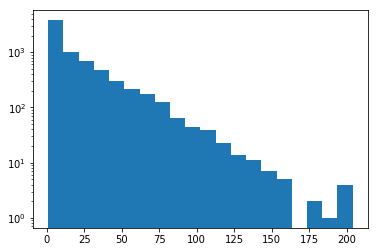

In [46]:
plt.hist(train['Bike ID'], bins=20)
plt.yscale('log');

In [ ]:
'2 AV F IND',
'21 ST-QNSBRIDGE F IND',
'34 ST-HERALD SQ BDFMNQRW BMT',
'34 ST-PENN STA 123 IRT',
'8 ST-NYU NRW BMT',
'BEDFORD-NOSTRAN G IND',
'BLEECKER ST 6DF IRT',
'CLASSON AV G IND',
'COURT SQ 7 IRT',
'GRAND ST L BMT',
'GRD CNTRL-42 ST 4567S IRT',
'HOYT-SCHER ACG IND',
'KINGSTON-THROOP C IND',
'MONTROSE AV L BMT']

In [48]:
col = ['time_of_day', 'entry_d', 'day_of_week', 'day_of_month', '1 AV L BMT',
       '14 ST 123FLM IRT',
        '15 ST-PROSPECT FG IND', '2 AV F IND',
       '21 ST-QNSBRIDGE F IND', '23 ST CE IND',
       '23 ST NRW BMT', '3 AV L BMT', '33 ST 6 IRT',
       '34 ST-HERALD SQ BDFMNQRW BMT', '34 ST-HUDSON YD 7 IRT',
       '34 ST-PENN STA 123 IRT', '4 AV-9 ST DFGMNR IND',
       '42 ST-BRYANT PK BDFM7 IND', '47-50 STS ROCK BDFM IND',
       '49 ST NQRW BMT', 
       '5 AVE 7BDFM IRT', '50 ST 1 IRT', '50 ST CE IND', '51 ST 6 IRT',
       '57 ST-7 AV NQRW BMT', '59 ST COLUMBUS 1ABCD IRT', '6 AV FLM123 BMT',
       '77 ST 6 IRT', 
       '8 ST-NYU NRW BMT', '86 ST 1 IRT', '86 ST BC IND', 
       '96 ST BC IND', '9TH STREET 1 PTH',
       'ATL AV-BARCLAY 2345BDNQR IRT',
       'BEDFORD AV L BMT', 'BEDFORD-NOSTRAN G IND', 'BERGEN ST 23 IRT',
       'BLEECKER ST 6DF IRT', 'BOROUGH HALL 2345R IRT',
       'BOROUGH HALL R2345 BMT', 'BOWERY JZ BMT', 'BOWLING GREEN 45 IRT',
       'CANAL ST ACE IND', 'CARROLL ST FG IND', 
       'CHAMBERS ST 123 IRT', 'CHRISTOPHER ST 1 IRT', 'CHRISTOPHER ST 1 PTH',
       'CITY / BUS 1 PTH', 'CLARK ST 23 IRT', 'CLASSON AV G IND',
       'CLINTON-WASH AV C IND', 'COURT SQ 7 IRT',
       'DEKALB AV BDNQR BMT', 'EAST BROADWAY F IND', 
       'FRANKLIN AV 2345S IRT', 'GRAHAM AV L BMT',
       'GRAND ARMY PLAZ 23 IRT', 'GRAND ST BD IND', 'GRAND ST L BMT',
       'GRD CNTRL-42 ST 4567S IRT', 'GREENPOINT AV G IND', 'HIGH ST AC IND',
       'HOYT-SCHER ACG IND', 'KINGSTON-THROOP C IND',
       'LEXINGTON AV/53 EM6 IND', 'LEXINGTON AV/63 F IND', 'MONTROSE AV L BMT',
        'NEVINS ST 2345 IRT',
       'PRESIDENT ST 25 IRT', 'PRINCE ST NRW BMT', 'QUEENSBORO PLZ 7NQW IRT',
       'SMITH-9 ST FG IND', 'SPRING ST 6 IRT', 'SPRING ST CE IND',
       'UNION ST R BMT', 'VERNON-JACKSON 7 IRT', 'WALL ST 23 IRT']

In [39]:
train.head()

zone       DATE  time_of_day  Bike ID   DELTA  1 AV L BMT  \
0  1 AV L BMT 2017-01-01           11        6  1063.0           1   
1  1 AV L BMT 2017-01-01           15       20  2286.0           1   
2  1 AV L BMT 2017-01-01           19       15  3805.0           1   
3  1 AV L BMT 2017-01-01           23       17  2702.0           1   
4  1 AV L BMT 2017-01-02           11        9  1963.0           1   

   103 ST 1 IRT  103 ST 6 IRT  14 ST 123FLM IRT  14 ST-UNION SQ 456LNQRW IRT  \
0             0             0                 0                            0   
1             0             0                 0                            0   
2             0             0                 0                            0   
3             0             0                 0                            0   
4             0             0                 0                            0   

   15 ST-PROSPECT FG IND  2 AV F IND  21 ST-QNSBRIDGE F IND  23 ST 6 IRT  \
0                      0           0                      0            0   
1                      0           0                      0            0   
2                      0           0                      0            0   
3                      0           0                      0            0   
4                      0           0                      0            0   

   23 ST CE IND  23 ST NRW BMT  3 AV L BMT  33 ST 6 IRT  \
0             0              0           0            0   
1             0              0           0            0   
2             0              0           0            0   
3             0              0           0            0   
4             0              0           0            0   

   34 ST-HERALD SQ BDFMNQRW BMT  34 ST-HUDSON YD 7 IRT  \
0                             0                      0   
1                             0                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   

   34 ST-PENN STA 123 IRT  4 AV-9 ST DFGMNR IND  42 ST-BRYANT PK BDFM7 IND  \
0                       0                     0                          0   
1                       0                     0                          0   
2                       0                     0                          0   
3                       0                     0                          0   
4                       0                     0                          0   

   47-50 STS ROCK BDFM IND  49 ST NQRW BMT  5 AV/53 ST EM IND  \
0                        0               0                  0   
1                        0               0                  0   
2                        0               0                  0   
3                        0               0                  0   
4                        0               0                  0   

   5 AV/59 ST NQRW BMT  5 AVE 7BDFM IRT  50 ST 1 IRT  50 ST CE IND  \
0                    0                0            0             0   
1                    0                0            0             0   
2                    0                0            0             0   
3                    0                0            0             0   
4                    0                0            0             0   

   51 ST 6 IRT  57 ST-7 AV NQRW BMT  59 ST COLUMBUS 1ABCD IRT  \
0            0                    0                         0   
1            0                    0                         0   
2            0                    0                         0   
3            0                    0                         0   
4            0                    0                         0   

   6 AV FLM123 BMT  72 ST 123 IRT  77 ST 6 IRT  8 ST-NYU NRW BMT  86 ST 1 IRT  \
0                0              0            0                 0            0   
1                0              0            0                 0            0   
2                0             

In [29]:
df.head()

Trip Duration          Start Time           Stop Time  Start Station ID  \
0              1436 2017-01-01 04:00:22 2017-01-01 04:24:19               146   
2797           1226 2017-01-01 15:49:21 2017-01-01 16:09:47              3349   
2798           1537 2017-01-01 15:50:22 2017-01-01 16:15:59              3349   
2799           1529 2017-01-01 15:50:26 2017-01-01 16:15:55              3349   
2800           1528 2017-01-01 15:50:32 2017-01-01 16:16:00              3349   

                    Start Station Name  Start Station Latitude  \
0                 Hudson St & Reade St               40.716250   
2797  Grand Army Plaza & Plaza St West               40.672968   
2798  Grand Army Plaza & Plaza St West               40.672968   
2799  Grand Army Plaza & Plaza St West               40.672968   
2800  Grand Army Plaza & Plaza St West               40.672968   

      Start Station Longitude  End Station ID             End Station Name  \
0                  -74.009106             276      Duane St & Greenwich St   
2797               -73.970880             241  DeKalb Ave & S Portland Ave   
2798               -73.970880             282           Kent Ave & S 11 St   
2799               -73.970880             282           Kent Ave & S 11 St   
2800               -73.970880             282           Kent Ave & S 11 St   

      End Station Latitude  End Station Longitude  Bike ID   User Type  \
0                40.717488             -74.010455    17121  Subscriber   
2797             40.689810             -73.974931    26107  Subscriber   
2798             40.707645             -73.968415    26380    Customer   
2799             40.707645             -73.968415    21310    Customer   
2800             40.707645             -73.968415    16737    Customer   

      Birth Year  Gender  month  year day_of_week  time_of_day  \
0         1980.0       1      1  2017      Sunday            7   
2797      1982.0       1      1  2017      Sunday           19   
2798         NaN       0      1  2017      Sunday           19   
2799         NaN       0      1  2017      Sunday           19   
2800         NaN       0      1  2017      Sunday           19   

                     zone        DATE  exits_d  entry_d  
0     CHAMBERS ST 123 IRT  2017-01-01    218.0    122.0  
2797  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0  
2798  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0  
2799  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0  
2800  PRESIDENT ST 25 IRT  2017-01-01    469.0    365.0

In [152]:
lin_model = sm.OLS(train['Bike ID'], train[col] )
result = lin_model.fit()
print(result.summary())
y_test = test['Bike ID']
y_pred = result.predict(test[col])

percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
print(np.mean(percent_error))

avg_error = (abs(y_pred - y_test + 1))
print(np.mean(avg_error))
test['pred'] = y_pred
test

                            OLS Regression Results                            
Dep. Variable:                Bike ID   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     155.4
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        21:20:21   Log-Likelihood:                -30622.
No. Observations:                7010   AIC:                         6.140e+04
Df Residuals:                    6933   BIC:                         6.193e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
time_of_day     

zone       DATE  time_of_day  Bike ID  exits_d  \
0                       1 AV L BMT 2017-01-23            7        3   1473.0   
1                       1 AV L BMT 2017-01-23           11       51   6842.0   
2                       1 AV L BMT 2017-01-24           11       18   6569.0   
3                       1 AV L BMT 2017-01-24           15       13   3950.0   
4                       1 AV L BMT 2017-01-24           19       27   6166.0   
5                       1 AV L BMT 2017-01-24           23       16   4743.0   
6                       1 AV L BMT 2017-01-25            7        4   1520.0   
7                       1 AV L BMT 2017-01-25           11       61   6285.0   
8                       1 AV L BMT 2017-01-25           15       34   3821.0   
9                       1 AV L BMT 2017-01-25           19       87   5973.0   
10                      1 AV L BMT 2017-01-25           23       33   4581.0   
11                      1 AV L BMT 2017-01-26            7        4   1467.0   
12                      1 AV L BMT 2017-01-26           11       45   6418.0   
13                      1 AV L BMT 2017-01-26           15       36   3903.0   
14                      1 AV L BMT 2017-01-26           19       85   6203.0   
15                      1 AV L BMT 2017-01-26           23       30   4779.0   
16                      1 AV L BMT 2017-01-27           11       54   6172.0   
17                      1 AV L BMT 2017-01-27           15       27   3939.0   
18                      1 AV L BMT 2017-01-27           19       71   7258.0   
19                      1 AV L BMT 2017-01-27           23       19   5422.0   
20                14 ST 123FLM IRT 2017-01-23            7        6    567.0   
21                14 ST 123FLM IRT 2017-01-23           11       65   3872.0   
22                14 ST 123FLM IRT 2017-01-24            7        2    578.0   
23                14 ST 123FLM IRT 2017-01-24           11       38   3945.0   
24                14 ST 123FLM IRT 2017-01-24           15        9   2342.0   
25                14 ST 123FLM IRT 2017-01-24           19       27   3766.0   
26                14 ST 123FLM IRT 2017-01-24           23       15   1913.0   
27                14 ST 123FLM IRT 2017-01-25            7        6    647.0   
28                14 ST 123FLM IRT 2017-01-25           11       77   4062.0   
29                14 ST 123FLM IRT 2017-01-25           15       61   2797.0   
30                14 ST 123FLM IRT 2017-01-25           19       86   3675.0   
31                14 ST 123FLM IRT 2017-01-25           23       75   2101.0   
32                14 ST 123FLM IRT 2017-01-26            7        8    599.0   
33                14 ST 123FLM IRT 2017-01-26           11       46   3987.0   
34                14 ST 123FLM IRT 2017-01-26           15       46   2677.0   
35                14 ST 123FLM IRT 2017-01-26           19       66   4072.0   
36                14 ST 123FLM IRT 2017-01-26           23       58   2016.0   
37                14 ST 123FLM IRT 2017-01-27            7        7    632.0   
38                14 ST 123FLM IRT 2017-01-27           11       83   3803.0   
39                14 ST 123FLM IRT 2017-01-27           15       40   2635.0   
40                14 ST 123FLM IRT 2017-01-27           19       67   4217.0   
41                14 ST 123FLM IRT 2017-01-27           23       33   2151.0   
42           15 ST-PROSPECT FG IND 2017-01-23            7        1     78.0   
43           15 ST-PROSPECT FG IND 2017-01-24           11        2    372.0   
44           15 ST-PROSPECT FG IND 2017-01-24           15        3    450.0   
45           15 ST-PROSPECT FG IND 2017-01-24           23        1    633.0   
46           15 ST-PROSPECT FG IND 2017-01-25           11       10    425.0   
47           15 ST-PROSPECT FG IND 2017-01-25           15       10    661.0   
48           15 ST-PROSPECT FG IND 2017-01-25           19       13   1459.0   
49           15 ST-PROSPECT FG

In [159]:
rfrmodel = RandomForestRegressor(n_estimators=100, n_jobs=-1)
reg = rfrmodel.fit(train[col], train['Bike ID'])

# print(rfrmodel.feature_importances_)
training_accuracy = reg.score(train[col], train['Bike ID'])
test_accuracy = reg.score(test[col], test['Bike ID'])

log_error = mean_squared_log_error(test['Bike ID'], rfrmodel.predict(test[col]))

print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy))
print("R^2 on test data:     %0.4f" % (test_accuracy))
print("Log on test data:     %0.4f" % (log_error))

y_test = test['log_bike_id']
y_pred = rfrmodel.predict(test[col])

percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
print("Percent Error:" , np.mean(percent_error))

avg_error = (abs(y_pred - y_test + 1))
print("Avg Error:", np.mean(avg_error))

test['percent_error'] = percent_error
test['avg_error'] = avg_error
test['pred'] = y_pred
# print(test)




############# based on standard predict ################
R^2 on training data: 0.9722
R^2 on test data:     0.8367
Log on test data:     0.2517
Percent Error: 5.318154615925216
Avg Error: 22.02156917701645


In [221]:
train[col].corr()['log_bike_id']

['2 AV F IND',
'21 ST-QNSBRIDGE F IND',
'34 ST-HERALD SQ BDFMNQRW BMT',
'34 ST-PENN STA 123 IRT',
'8 ST-NYU NRW BMT',
'BEDFORD-NOSTRAN G IND',
'BLEECKER ST 6DF IRT',
'CLASSON AV G IND',
'COURT SQ 7 IRT',
'GRAND ST L BMT',
'GRD CNTRL-42 ST 4567S IRT',
'HOYT-SCHER ACG IND',
'KINGSTON-THROOP C IND',
'MONTROSE AV L BMT']

log_bike_id                     1.000000
time_of_day                     0.205408
entry_d                         0.014789
1 AV L BMT                      0.048308
14 ST 123FLM IRT                0.088754
15 ST-PROSPECT FG IND          -0.093506
2 AV F IND                      0.114967
21 ST-QNSBRIDGE F IND          -0.109886
23 ST CE IND                    0.083325
23 ST NRW BMT                   0.054798
3 AV L BMT                      0.080989
33 ST 6 IRT                     0.005761
34 ST-HERALD SQ BDFMNQRW BMT    0.126245
34 ST-HUDSON YD 7 IRT          -0.062855
34 ST-PENN STA 123 IRT          0.128748
4 AV-9 ST DFGMNR IND           -0.081058
42 ST-BRYANT PK BDFM7 IND       0.041353
47-50 STS ROCK BDFM IND        -0.002368
49 ST NQRW BMT                  0.006844
5 AVE 7BDFM IRT                 0.088589
50 ST 1 IRT                    -0.019366
50 ST CE IND                    0.062208
51 ST 6 IRT                     0.014993
57 ST-7 AV NQRW BMT             0.073117
59 ST COLUMBUS 1

In [50]:
col = ['time_of_day',  'day_of_week', 'day_of_month', '1 AV L BMT',
       '14 ST 123FLM IRT',
        '15 ST-PROSPECT FG IND', '2 AV F IND',
       '21 ST-QNSBRIDGE F IND', '23 ST CE IND',
       '23 ST NRW BMT', '3 AV L BMT', '33 ST 6 IRT',
       '34 ST-HERALD SQ BDFMNQRW BMT', '34 ST-HUDSON YD 7 IRT',
       '34 ST-PENN STA 123 IRT', '4 AV-9 ST DFGMNR IND',
       '42 ST-BRYANT PK BDFM7 IND', '47-50 STS ROCK BDFM IND',
       '49 ST NQRW BMT', 
       '5 AVE 7BDFM IRT', '50 ST 1 IRT', '50 ST CE IND', '51 ST 6 IRT',
       '57 ST-7 AV NQRW BMT', '59 ST COLUMBUS 1ABCD IRT', '6 AV FLM123 BMT',
       '77 ST 6 IRT', 
       '8 ST-NYU NRW BMT', '86 ST 1 IRT', '86 ST BC IND', 
       '96 ST BC IND', '9TH STREET 1 PTH',
       'ATL AV-BARCLAY 2345BDNQR IRT',
       'BEDFORD AV L BMT', 'BEDFORD-NOSTRAN G IND', 'BERGEN ST 23 IRT',
       'BLEECKER ST 6DF IRT', 'BOROUGH HALL 2345R IRT',
       'BOROUGH HALL R2345 BMT', 'BOWERY JZ BMT', 'BOWLING GREEN 45 IRT',
       'CANAL ST ACE IND', 'CARROLL ST FG IND', 
       'CHAMBERS ST 123 IRT', 'CHRISTOPHER ST 1 IRT', 'CHRISTOPHER ST 1 PTH',
       'CITY / BUS 1 PTH', 'CLARK ST 23 IRT', 'CLASSON AV G IND',
       'CLINTON-WASH AV C IND', 'COURT SQ 7 IRT',
       'DEKALB AV BDNQR BMT', 'EAST BROADWAY F IND', 
       'FRANKLIN AV 2345S IRT', 'GRAHAM AV L BMT',
       'GRAND ARMY PLAZ 23 IRT', 'GRAND ST BD IND', 'GRAND ST L BMT',
       'GRD CNTRL-42 ST 4567S IRT', 'GREENPOINT AV G IND', 'HIGH ST AC IND',
       'HOYT-SCHER ACG IND', 'KINGSTON-THROOP C IND',
       'LEXINGTON AV/53 EM6 IND', 'LEXINGTON AV/63 F IND', 'MONTROSE AV L BMT',
        'NEVINS ST 2345 IRT',
       'PRESIDENT ST 25 IRT', 'PRINCE ST NRW BMT', 'QUEENSBORO PLZ 7NQW IRT',
       'SMITH-9 ST FG IND', 'SPRING ST 6 IRT', 'SPRING ST CE IND',
       'UNION ST R BMT', 'VERNON-JACKSON 7 IRT', 'WALL ST 23 IRT']

In [51]:
rfrmodel = RandomForestRegressor(n_estimators=1000)
reg = rfrmodel.fit(train[col], train['log_bike_id'])

# print(rfrmodel.feature_importances_)
training_accuracy = reg.score(train[col], train['log_bike_id'])
test_accuracy = reg.score(test[col], test['log_bike_id'])

log_error = mean_squared_log_error(test['log_bike_id'], rfrmodel.predict(test[col]))

print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy))
print("R^2 on test data:     %0.4f" % (test_accuracy))
print("Log on test data:     %0.4f" % (log_error))

y_test = test['log_bike_id']
y_pred = rfrmodel.predict(test[col])

percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
print("Percent Error:" , np.mean(percent_error))

avg_error = (abs(y_pred - y_test + 1))
print("Avg Error:", np.mean(avg_error))

test['percent_error'] = percent_error
test['avg_error'] = avg_error
test['pred'] = y_pred
# print(test)




############# based on standard predict ################
R^2 on training data: 0.9727
R^2 on test data:     0.6932
Log on test data:     0.0806
Percent Error: 0.35733772456990015
Avg Error: 0.7805569512509428


In [179]:
n_estimators_range = range(1,100)
min_samples_split_range = range(2,50)
min_samples_leaf_range = range(2,50)
max_depth_range = range(1,20)

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# param_grid = dict({
#     'n_estimators': n_estimators_range,
#     'min_samples_split': min_samples_split_range,
#     'min_samples_leaf': min_samples_leaf_range,
#     'max_depth': max_depth_range,
# })

search = RandomizedSearchCV(rfrmodel, param_grid)
search.fit(train[col], train['log_bike_id'])

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=33, min_samples_split=13,
           min_weight_fraction_leaf=0.0, n_estimators=99, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [180]:
print(search.best_score_)
print(search.best_params_)
print(search.best_estimator_)

0.18226460704244093
{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [194]:
clf = GradientBoostingRegressor()

clf.fit(train[col], train['log_bike_id'])
y_test = train['log_bike_id']
y_pred = clf.predict(train[col])

percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
print("Percent Error:" , np.mean(percent_error))

avg_error = (abs(y_pred - y_test + 1))
print("Avg Error:", np.mean(avg_error))

test['percent_error'] = percent_error
test['avg_error'] = avg_error
# test['pred'] = y_pred


Percent Error: 0.528080070884028
Avg Error: 1.0318319177146358


In [149]:
sum = 0.0

for x in range(len(y_pred)):
    p = np.log(y_pred[x] + 1)
    r = np.log(y_test[x] + 1)
    sum = sum + (p - r)**2

rmsle = (sum / len(y_pred)) **.5

In [150]:
rmsle

1.6964154103481892

In [258]:
test['unlog_pred'] = np.log(test['pred'])

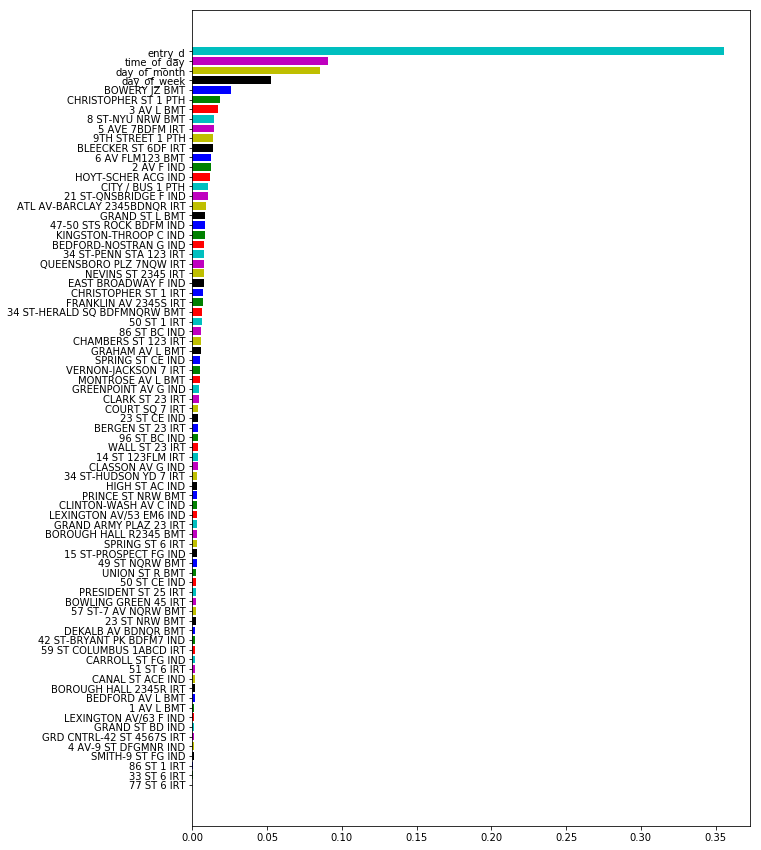

In [123]:
featurelist=train[col].columns
featureimp= reg.feature_importances_

tmp_df=featurelist.to_frame(index=False)
tmp_df=tmp_df.rename(columns={0:'feature'})
tmp_df['prime']=featureimp
feature_df=tmp_df.sort_values(by=['prime'], ascending=True)

fig=plt.figure(figsize=(10,15))
ax1=fig.add_subplot(111)
ax1.barh(feature_df['feature'],feature_df['prime'],color='rgbkymc');

In [259]:
test.head()

zone       DATE  time_of_day  Bike ID  exits_d  entry_d  1 AV L BMT  \
0  1 AV L BMT 2017-01-23            7        3   1473.0    601.0           1   
1  1 AV L BMT 2017-01-23           11       51   6842.0   5415.0           1   
2  1 AV L BMT 2017-01-24           11       18   6569.0   5808.0           1   
3  1 AV L BMT 2017-01-24           15       13   3950.0   3386.0           1   
4  1 AV L BMT 2017-01-24           19       27   6166.0   7242.0           1   

   14 ST 123FLM IRT  15 ST-PROSPECT FG IND  2 AV F IND  21 ST-QNSBRIDGE F IND  \
0                 0                      0           0                      0   
1                 0                      0           0                      0   
2                 0                      0           0                      0   
3                 0                      0           0                      0   
4                 0                      0           0                      0   

   23 ST 1 IRT  23 ST CE IND  23 ST NRW BMT  28 ST 6 IRT  3 AV L BMT  \
0            0             0              0            0           0   
1            0             0              0            0           0   
2            0             0              0            0           0   
3            0             0              0            0           0   
4            0             0              0            0           0   

   33 ST 6 IRT  34 ST-HERALD SQ BDFMNQRW BMT  34 ST-HUDSON YD 7 IRT  \
0            0                             0                      0   
1            0                             0                      0   
2            0                             0                      0   
3            0                             0                      0   
4            0                             0                      0   

   34 ST-PENN STA 123 IRT  4 AV-9 ST DFGMNR IND  42 ST-BRYANT PK BDFM7 IND  \
0                       0                     0                          0   
1                       0                     0                          0   
2                       0                     0                          0   
3                       0                     0                          0   
4                       0                     0                          0   

   47-50 STS ROCK BDFM IND  49 ST NQRW BMT  5 AVE 7BDFM IRT  50 ST 1 IRT  \
0                        0               0                0            0   
1                        0               0                0            0   
2                        0               0                0            0   
3                        0               0                0            0   
4                        0               0                0            0   

   50 ST CE IND  51 ST 6 IRT  57 ST-7 AV NQRW BMT  59 ST COLUMBUS 1ABCD IRT  \
0             0            0                    0                         0   
1             0            0                    0                         0   
2             0            0                    0                         0   
3             0            0                    0                         0   
4             0            0                    0                         0   

   6 AV FLM123 BMT  7 AV FG IND  77 ST 6 IRT  8 AV ACEL BMT  8 ST-NYU NRW BMT  \
0                0            0            0              0                 0   
1                0            0            0              0                 0   
2                0            0            0              0                 0   
3                0            0            0              0                 0   
4                0            0            0              0                 0   

   86 ST 1 IRT  86 ST BC IND  96 ST BC IND  9TH STREET 1 PTH  \
0            0             0             0                 0   
1            0             0             0                 0   
2            0             0             0                 0   
3            0             0         

In [267]:
np.log(3)

1.584962500721156

In [270]:
np.e**1.0986122886681098

3.0

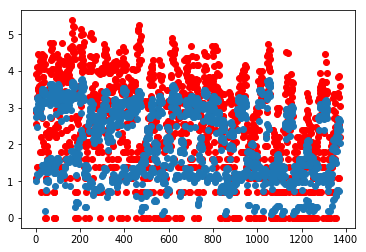

In [60]:
plt.plot(y_test, 'o', color='red');
plt.plot(y_pred, 'o');

In [244]:
min(y_pred)

0.06931471805599453

In [245]:
max(y_pred)

4.816281023263147

In [ ]:
min()

In [14]:
from catboost import Pool, CatBoostRegressor

In [52]:
col=['zone', 'time_of_day', 'entry_d', 'day_of_week', 'day_of_month']

In [28]:
train

zone       DATE  time_of_day  Bike ID   exits_d  \
0                      1 AV L BMT 2017-01-01           11        6    1063.0   
1                      1 AV L BMT 2017-01-01           15       20    2286.0   
2                      1 AV L BMT 2017-01-01           19       15    3805.0   
3                      1 AV L BMT 2017-01-01           23       17    2702.0   
4                      1 AV L BMT 2017-01-02           11        9    1963.0   
5                      1 AV L BMT 2017-01-02           15       10    3357.0   
6                      1 AV L BMT 2017-01-02           19        9    4602.0   
7                      1 AV L BMT 2017-01-02           23       12    2870.0   
8                      1 AV L BMT 2017-01-03            7        2    1387.0   
9                      1 AV L BMT 2017-01-03           11       36    6795.0   
10                     1 AV L BMT 2017-01-03           15        4    3595.0   
11                     1 AV L BMT 2017-01-03           19       36    6582.0   
12                     1 AV L BMT 2017-01-03           23       20    4035.0   
13                     1 AV L BMT 2017-01-04            7        3    1514.0   
14                     1 AV L BMT 2017-01-04           11       64    6732.0   
15                     1 AV L BMT 2017-01-04           15       35    3611.0   
16                     1 AV L BMT 2017-01-04           19       87    6311.0   
17                     1 AV L BMT 2017-01-04           23       30    4406.0   
18                     1 AV L BMT 2017-01-05            7        5    1450.0   
19                     1 AV L BMT 2017-01-05           11       48    7029.0   
20                     1 AV L BMT 2017-01-05           15       22    3646.0   
21                     1 AV L BMT 2017-01-05           19       73    6696.0   
22                     1 AV L BMT 2017-01-05           23       24    4598.0   
23                     1 AV L BMT 2017-01-06            7        1    1414.0   
24                     1 AV L BMT 2017-01-06           11       29    6856.0   
25                     1 AV L BMT 2017-01-06           15       26    3683.0   
26                     1 AV L BMT 2017-01-06           19       65    6955.0   
27                     1 AV L BMT 2017-01-06           23       24    5133.0   
28                     1 AV L BMT 2017-01-07            7        1     415.0   
29                     1 AV L BMT 2017-01-07           11        9    1743.0   
30                     1 AV L BMT 2017-01-07           15        3    2726.0   
31                     1 AV L BMT 2017-01-07           19        2    3704.0   
32                     1 AV L BMT 2017-01-07           23        7    2870.0   
33                     1 AV L BMT 2017-01-08           15        9    2554.0   
34                     1 AV L BMT 2017-01-08           19       15    3143.0   
35                     1 AV L BMT 2017-01-08           23        5    1649.0   
36                     1 AV L BMT 2017-01-09            7        2    1319.0   
37                     1 AV L BMT 2017-01-09           11       18    6545.0   
38                     1 AV L BMT 2017-01-09           15       15    3571.0   
39                     1 AV L BMT 2017-01-09           19       38    6427.0   
40                     1 AV L BMT 2017-01-09           23       10    4511.0   
41                     1 AV L BMT 2017-01-10            7        4    1430.0   
42                     1 AV L BMT 2017-01-10           11       29    6098.0   
43                     1 AV L BMT 2017-01-10           15       16    3367.0   
44                     1 AV L BMT 2017-01-10           19       62    4963.0   
45                     1 AV L BMT 2017-01-10           23       29    4176.0   
46                     1 AV L BMT 2017-01-11            7        4    1476.0   
47                     1 AV L BMT 2017-01-11           11       42    6893.0   
48                     1 AV L BMT 2017-01-11           15       23    3644.0   
49                     1 AV L

In [ ]:
cat = [0]

In [55]:
cat_train = train[col]
cat_test = test[col]
train_pool = Pool(cat_train, train['log_bike_id'], cat_features=[0])
test_pool = Pool(cat_test, cat_features=[0])

In [74]:
catmodel = CatBoostRegressor(iterations=100, depth=15)
catmodel.fit(train_pool)

0:	learn: 2.5428871	total: 17.3ms	remaining: 1.72s
1:	learn: 2.4781925	total: 377ms	remaining: 18.5s
2:	learn: 2.4133453	total: 457ms	remaining: 14.8s
3:	learn: 2.3513121	total: 625ms	remaining: 15s
4:	learn: 2.2912758	total: 633ms	remaining: 12s
5:	learn: 2.2321850	total: 642ms	remaining: 10.1s
6:	learn: 2.1751780	total: 683ms	remaining: 9.07s
7:	learn: 2.1205136	total: 760ms	remaining: 8.74s
8:	learn: 2.0674688	total: 767ms	remaining: 7.76s
9:	learn: 2.0162462	total: 790ms	remaining: 7.11s
10:	learn: 1.9662961	total: 875ms	remaining: 7.08s
11:	learn: 1.9197043	total: 878ms	remaining: 6.44s
12:	learn: 1.8730881	total: 960ms	remaining: 6.42s
13:	learn: 1.8277476	total: 1.15s	remaining: 7.04s
14:	learn: 1.7830643	total: 1.36s	remaining: 7.72s
15:	learn: 1.7423177	total: 1.38s	remaining: 7.25s
16:	learn: 1.7023684	total: 1.47s	remaining: 7.2s
17:	learn: 1.6637044	total: 1.5s	remaining: 6.83s
18:	learn: 1.6262936	total: 1.5s	remaining: 6.42s
19:	learn: 1.5904549	total: 1.52s	remaining: 6.

In [71]:
y_pred = catmodel.predict(test_pool)
y_test = test['log_bike_id']

In [72]:
percent_error = (abs(y_pred - y_test + 1))/abs(y_test + 1)
print("Percent Error:" , np.mean(percent_error))

avg_error = (abs(y_pred - y_test + 1))
print("Avg Error:", np.mean(avg_error))
plt.plot(y_test, 'o', color='red');
plt.plot(y_pred, 'o');

Percent Error: 0.38574000244127854
Avg Error: 0.8616346948008956
